In [64]:
import pandas as pd
import numpy as np

df = pd.read_csv('/Users/qyu/Desktop/hbu_analytics/BTC_minute_bar.csv',index_col=0)
tickers = ['BTCUSD']
ret = pd.DataFrame(columns = tickers)
for ticker in tickers:  
    tmp = df[df['sym'] == ticker]
    ret[ticker] = tmp['close'].pct_change()
# convert datetime to timestamp object and set it as index for ret , must be comparible with pd.Timestamp('2018-01-01 00:01:00')
ret.index = tmp.datetime.astype('datetime64[ns]')


In [65]:
# some constants
LOOK_BACK_HORIZON = 100
LOOK_BACK = 80
SMOOTH_DAY = 3 
LOOK_BACK_TOTAL = LOOK_BACK + SMOOTH_DAY + 1 

HALF_life = 10
CORR_ADJ = 2 

def get_adjusted_cov(ret):
    """
    Todo: shrink cov matrix if necessary

    """
    # some params
    look_back_minutes = LOOK_BACK_HORIZON
    
    # get return data, transfer to numpy
    ret = ret[-look_back_minutes:]
    ret_mat = ret.to_numpy()

    # some constants half_life, corr_adj
    half_life = HALF_life
    corr_adj = CORR_ADJ
    
    # given desired half life of h periods, the decay parameter is: 
    delta = 0.5 ** (1 / half_life)

    # N assets over T periods
    T, N = ret_mat.shape

    # Construct a weighting vector
    deltas = [delta ** (T - t) for t in range(T)]
    weight = np.diag(deltas)

    # And the total weight (condition on k, here k = 0 to begin) weight_t_k = sum(deltas[k:])
    weight_t_0 = sum(deltas)
    covmat_0 = (np.sqrt(weight) @ ret_mat).T @ (np.sqrt(weight) @ ret_mat) / weight_t_0

    # get adjusted covariance matrix using 
    cov_final = covmat_0.copy()
    for k in range(1, corr_adj + 1):
        # We can now denote use the following notion for covariance and serial-covariance matrices
        A = sum(deltas[k:]) # weight_t_k
        B = np.vstack((np.zeros((k,N)) , ret_mat[k:, :]))
        cov_k = (np.sqrt(weight) @ ret_mat).T @ (np.sqrt(weight) @ B) / A
        # The formula to estimate rhe serial-correltaion adjusted covariance matrix is:
        cov_final = cov_final + (1 - k / (corr_adj + 1)) * (cov_k + cov_k.T)
    return cov_final 

def get_adjusted_realized_vol(ret):  
    # This is the smoothed realized vol similar to QMS's risk model 
    cov_final = get_adjusted_cov(ret)
    variances = np.diag(cov_final)
    return np.sqrt(variances)

def populate_realized_vol(tickers, ret, start_date):
    # this start_index should be at least greater than corr_adj which is 2 
    # create vol dataframe with columns as tickers, index as dates from start_date
    vol = pd.DataFrame(columns=tickers, index = ret.loc[ret.index >= start_date].index)
    for dt in vol.index[1:]:
        sub_ret = ret.loc[ret.index <= dt] #ret.loc[:dt, :]
        # if the length of sub_ret is greater than LOOK_BACK_TOTAL, then we choose only the last LOOK_BACK_TOTAL rows
        if len(sub_ret) > LOOK_BACK_TOTAL:
            sub_ret = sub_ret[-LOOK_BACK_TOTAL:]
        vol.loc[dt, :] = get_adjusted_realized_vol(sub_ret)
    return vol

# generate signal 
def get_signal_df(df_vol, df_ret, t = 'BTCUSD'):
    vol, ret = df_vol.copy(), df_ret.copy()
    v = vol[[t]].rename(columns = {t: "rv"})
    r = ret.loc[v.index, [t]].rename(columns = {t: "ret"})
    signal_df = pd.concat([r,v], axis=1)
    signal_df['ret_next'] = signal_df['ret'].shift(-1)
    signal_df['ret_next_lag1'] = signal_df['ret'].shift(-2)
    signal_df['ret_next_lag2'] = signal_df['ret'].shift(-3)
    signal_df = signal_df.dropna() # safe to drop na, any better idea
    return signal_df

def risk_prem_signal(signal_df, look_back):
    df = signal_df.copy()
    # signal = np.where((df['daily_rv'] - df['daily_rv'].shift(look_back)).dropna() > 0, 1, -1)
    df['signal'] = (df['rv'] - df['rv'].shift(look_back))
    df['signal'] = df['signal'].rolling(5).median()
    df['signal'] = df['signal'].dropna()                 
    df['signal_z'] = np.where(df['signal'] > 0, 1, np.where(df['signal'] < 0, 0, 0))
    return df 


In [66]:
def cal_max_dd(data):
    cum_max = data.cummax()
    drawdown = data - cum_max
    max_drawdown = drawdown.min()
    return max_drawdown

def mini_backtest(df_input, prediction, x_min_rolling_ret):
    scale_factor = 60 * 24 / x_min_rolling_ret
    df = df_input.copy()
    avg_abs_pos = df['POS'].abs().mean()
    gross_return = df[prediction].mean() * 100 * 252 * scale_factor
    net_return = (df[prediction] - df['TC']).mean() * 100 * 252 * scale_factor
    vol = df[prediction].std() * 100 * np.sqrt(252 * scale_factor)
    gross_sr = df[prediction].mean() * np.sqrt(252 * scale_factor) / df[prediction].std()
    net_sr = (df[prediction] - df['TC']).mean() * np.sqrt(252* scale_factor) / df[prediction].std()
    tc = df['TC'].mean() * 100 * 252 * scale_factor
    signal_turnover = df['POS'].diff().fillna(0).abs().mean() * 252 * scale_factor
    max_dd = cal_max_dd(df[prediction].cumsum())
    
    return pd.Series(
        [avg_abs_pos, gross_return, net_return, vol, gross_sr, net_sr, tc, signal_turnover, max_dd],
        index = ['avg_abs_pos', 'gross_return', 'net_return', 'vol', 'gross_sr',
                 'net_sr', 'tc', 'signal_turnover', 'max_dd'])

def run_backtest(signal_df, lookback_window, prediction, x_min_rolling_ret):
    res_stat = []
    res_gross_pnl = []
    res_net_pnl = []
    for lookback in lookback_window: 
        """
        SIGNAL HERE 
        """
        signal_df = risk_prem_signal(signal_df, lookback)
        #signal_df['signal_z'] = signal_df['signal'] #.clip(-2, 2)

        signal_df['POS'] = signal_df['signal_z']
        signal_df['STRATEGY_RUN'] = signal_df['signal_z'] * signal_df[prediction]
        signal_df['TC'] = 0
        res_stat.append(pd.DataFrame(mini_backtest(signal_df, "STRATEGY_RUN", x_min_rolling_ret), columns=[f"lookback_{lookback}"]))
        res_gross_pnl.append(signal_df["STRATEGY_RUN"])
        # res_net_pnl.append(signal_df["STRATEGY_RUN"] - signal_df["TC"])
    stats_df = pd.concat(res_stat, axis=1)
    return res_gross_pnl, stats_df


# Now start preparing data and run the backtest

In [67]:
def get_rolling_x_minute_ret(ret, start_date, rolling_window):
    """
    get 30 minutes return data based on minute return data 
    """
    ret = ret.copy()
    ret = ret.loc[ret.index >= start_date]
    # Rolling sum of returns for a x-minute window
    ret['BTCUSD'] = ret['BTCUSD'].rolling(window=rolling_window).sum()
    # get only data every x minutes
    ret = ret[ret.index.minute % rolling_window == 0]
    return ret

def get_adjusted_vol(ret, start_date):
    vol = pd.DataFrame(columns=tickers, index = ret.loc[ret.index >= start_date].index)
    for dt in vol.index[1:]:
        sub_ret = ret.loc[ret.index <= dt] #ret.loc[:dt, :]
        vol.loc[dt, :] = get_adjusted_realized_vol(sub_ret)
        # print(f'{dt} done!')
    return vol 

# parameters
start_date = pd.Timestamp('2019-01-01 00:01:00')
ret_rolling_window = 60 

# initialize the ret and vol df 
ret = get_rolling_x_minute_ret(ret, start_date=start_date, rolling_window=ret_rolling_window)
vol = get_adjusted_vol(ret, start_date)



/var/folders/v7/ssz5t3wn3q73dwfcjlf4snz40000gn/T/ipykernel_20671/98812870.py:46: RuntimeWarning: invalid value encountered in divide
  cov_k = (np.sqrt(weight) @ ret_mat).T @ (np.sqrt(weight) @ B) / A


In [68]:
signal_df = get_signal_df(vol, ret)
signal_df

,ret,rv,ret_next,ret_next_lag1,ret_next_lag2
datetime,,,,,
2019-01-01 03:00:00,0.000519,0.003977,0.000841,0.000432,0.001748
2019-01-01 04:00:00,0.000841,0.003369,0.000432,0.001748,0.000602
2019-01-01 05:00:00,0.000432,0.002921,0.001748,0.000602,0.002637
2019-01-01 06:00:00,0.001748,0.002961,0.000602,0.002637,0.003042
2019-01-01 07:00:00,0.000602,0.002702,0.002637,0.003042,-0.004911
...,...,...,...,...,...
2023-08-19 16:00:00,0.007979,0.007433,0.001671,-0.006419,0.002475
2023-08-19 17:00:00,0.001671,0.007218,-0.006419,0.002475,0.000368
2023-08-19 18:00:00,-0.006419,0.007543,0.002475,0.000368,-0.003032


In [69]:
lookback_window = [5, 10, 20, 40, 60, 70, 80, 90, 100, 120]
res_gross_pnl, stats_df = run_backtest(signal_df, lookback_window, prediction = 'ret_next', x_min_rolling_ret=ret_rolling_window)
stats_df

,lookback_5,lookback_10,lookback_20,lookback_40,lookback_60,lookback_70,lookback_80,lookback_90,lookback_100,lookback_120
avg_abs_pos,0.316419,0.372930,0.425251,0.473186,0.474640,0.476661,0.471683,0.473235,0.467345,0.476489
gross_return,24.365702,16.617523,28.279229,25.907442,24.684724,28.363707,36.766924,24.438290,23.014692,29.207602
net_return,24.365702,16.617523,28.279229,25.907442,24.684724,28.363707,36.766924,24.438290,23.014692,29.207602
vol,39.004791,40.990806,43.857464,44.216575,45.826427,45.663783,45.320447,46.126085,46.302823,46.746909
gross_sr,0.624685,0.405396,0.644799,0.585921,0.538657,0.621142,0.811266,0.529815,0.497047,0.624803
net_sr,0.624685,0.405396,0.644799,0.585921,0.538657,0.621142,0.811266,0.529815,0.497047,0.624803
tc,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
signal_turnover,536.444006,374.720820,255.477918,201.520505,187.062303,171.560726,179.311514,170.070189,172.753155,169.175868
max_dd,-0.773891,-1.014840,-0.862541,-0.639345,-0.830631,-0.767587,-0.785372,-0.785621,-0.836124,-0.765901


Text(0.5, 1.0, 'BTC Risk Premium CumRet')

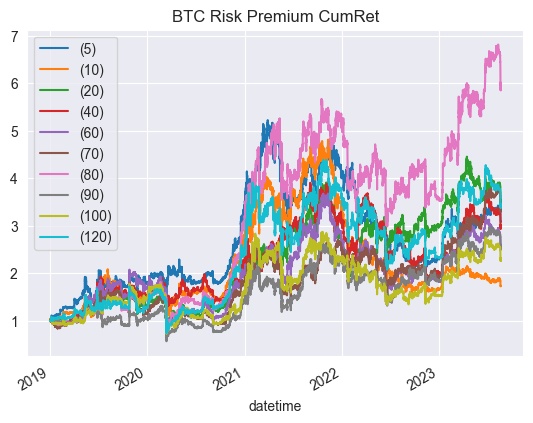

In [70]:
import matplotlib.pyplot as plt
for lookback, pnl in zip(lookback_window, res_gross_pnl):
    p = (pnl + 1).cumprod().plot(label=f'({lookback})')
plt.legend()
plt.title("BTC Risk Premium CumRet")